# Tutorial 2: Calculating travel time matrices with `r5py` and estimating carbon footprints by GHG emission factors

```{admonition} Credits:

This tutorial was written by Henrikki Tenkanen, Christoph Fink & Willem Klumpenhouwer (i.e. `r5py` developer team).
You can read the [full documentation of `r5py`](https://r5py.readthedocs.io/en/latest/user-guide/user-manual/advanced-use.html#use-a-custom-installation-of-r5) which includes much more information and detailed user manual in case you are interested in using the library for research purposes.

```

**Lesson objectives**

This tutorial focuses on utilising  `r5py` library to find shortest paths along the given street network based on travel times or distance by car for multiple origin destination pairs/zones simultaneously. First, we will learn how to calculate travel times and distances from a single origin-destination pairs in the road network graph. Then we will explore the locozmier data to build the travel time matrices, detailed itenaries and CO2 emission matrices.  

## Introduction to `r5py`

In this tutorial, we will learn how to calculate travel times and detailed public transport travel itineraries with `r5py` between H3 hexgaons spread around the city center area of Helsinki, Finland. **R5py** is a Python library for routing and calculating travel time matrices on multimodal transport networks (walk, bike, public transport, and car).
It provides a simple and friendly interface to R<sup>5</sup> (*the Rapid Realistic Routing on Real-world and Reimagined networks*) which is a [routing engine](https://github.com/conveyal/r5) developed by [Conveyal](https://conveyal.com/). `R5py` is designed to interact with [GeoPandas](https://geopandas.org) GeoDataFrames, and it is inspired by [r5r](https://ipeagit.github.io/r5r) which is a similar wrapper developed for R. `R5py` exposes some of R5’s functionality via its [Python API](reference.html), in a syntax similar to r5r’s. At the time of this writing, only the computation of travel time matrices has been fully implemented. Over time, `r5py` will be expanded to incorporate other functionalities from R5.
When calculating travel times with `r5py`, you typically need a couple of datasets: 

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) -format: 
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit. 
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g. by cropping the data or adding special costs for travelling (e.g. for considering slope when cycling/walking). When doing this, you should follow the instructions at [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) -format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about [GTFS standard from here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5py` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing e.g. the bus and metro connections. 


### Where to get these datasets?

Here are a few places from where you can download the datasets for creating the routable network:

- **OpenStreetMap data in PBF-format**:

  - [pyrosm](https://pyrosm.readthedocs.io/en/latest/basics.html#protobuf-file-what-is-it-and-how-to-get-one)  -library. Allows downloading data directly from Python (based on GeoFabrik and BBBike).
  - [pydriosm](https://pydriosm.readthedocs.io/en/latest/quick-start.html#download-data) -library. Allows downloading data directly from Python (based on GeoFabrik and BBBike).
  - [GeoFabrik](http://download.geofabrik.de/) -website. Has data extracts for many pre-defined areas (countries, regions, etc).
  - [BBBike](https://download.bbbike.org/osm/bbbike/) -website. Has data extracts readily available for many cities across the world. Also supports downloading data by [specifying your own area or interest](https://extract.bbbike.org/).
  - [Protomaps](https://protomaps.com/downloads/osm) -website. Allows to download the data with custom extent by specifying your own area of interest.


- **GTFS data**:  
  - [Transitfeeds](https://transitfeeds.com/) -website. Easy to navigate and find GTFS data for different countries and cities. Includes current and historical GTFS data. Notice: The site will be depracated in the future.  
  - [Mobility Database](https://database.mobilitydata.org) -website. Will eventually replace TransitFeeds -website. 
  - [Transitland](https://www.transit.land/operators) -website. Find data based on country, operator or feed name. Includes current and historical GTFS data.
    
 


import sys
import os

if "MEM_LIMIT" in os.environ:  # binder/kubernetes!
    max_memory = int(os.environ["MEM_LIMIT"]) / 2
    sys.argv.extend(["--max-memory", f"{max_memory}"])

In [103]:
import sys
sys.argv.append([
    "--r5-classpath", 
    "https://github.com/DigitalGeographyLab/r5/releases/download/v6.9-post16-g1054c1e-20230619/r5-v6.9-post16-g1054c1e-20230619-all.jar"
])

import pandas as pd
import geopandas as gpd
import osmnx as ox
import r5py
import r5py.sampledata.helsinki


### Load transport network using `r5py`

Virtually all operations of `r5py` require a transport network. In this example, we use data from Helsinki metropolitan area, which you can easily obtain from the `r5py.sampledata.helsinki` library. The files will be downloaded automatically to a temporary folder on your computer when you call the variables `*.osm_pbf` and `*.gtfs`:

In [104]:
# Download OSM data
r5py.sampledata.helsinki.osm_pbf

SampleDataSet('C:/Users/deys1/AppData/Local/r5py/sampledata/kantakaupunki.osm.pbf')

In [105]:
# Download GTFS data
r5py.sampledata.helsinki.gtfs

SampleDataSet('C:/Users/deys1/AppData/Local/r5py/sampledata/helsinki_gtfs.zip')

To import the street and public transport networks, instantiate an `r5py.TransportNetwork` with the file paths to the OSM extract and the GTFS files:

In [106]:
from r5py import TransportNetwork

# Get the filepaths to sample data (OSM and GTFS)
helsinki_osm = r5py.sampledata.helsinki.osm_pbf
helsinki_gtfs = r5py.sampledata.helsinki.gtfs

transport_network = TransportNetwork(
    # OSM data
    helsinki_osm,
    
    # A list of GTFS file(s)
    [
        helsinki_gtfs
    ]
)

At this stage, `r5py` has created the routable transport network and it is stored in the `transport_network` variable. We can now start using this network for doing the travel time calculations. 

`````{admonition} Info regarding "An illegal reflective access operation has occurred"
:class: tip
If you receive a Warning when running the cell above (*"WARNING: An illegal reflective access operation has occurred"*), it is due to using an older version of OpenJDK library (version 11). `r5r` only supports the version 11 of OpenJDK at this stage which is the reason why we also use it here. If you plan to use only `r5py` and want to get rid of the warning, you can update the OpenJDK to it's latest version with mamba:

```
$ conda activate geo

$ mamba install -c conda-forge openjdk=20
```

`````



### Load and prepare the origin and destination data (Locomizer)

Let's start by downloading a sample dataset into a geopandas `GeoDataFrame` that we can use as our destination locations. To make testing the library easier, we have prepared....

#### Recalling the single origin-destination locations from Tutorial 1

Let's recall the origin and destination locations in our earlier tutorial and use those as our **origin** and **destination** locations here for demonstration purposes. We will first define the single origin and destination GeoDataFrame for the tutorial described above. Then we shall proceed with all the OD hexagon centroids in the locomizer data, which can be found within the `hexagon_gdf`:

In [107]:
from shapely.geometry import Point 
import osmnx as ox 

# Origin
orig_y, orig_x = 60.16874416, 24.95721918 ##  60.2348923, 24.596135  ##  60.1699013,24.8242217  ##  
# Destination
dest_y, dest_x =   60.1622494, 24.9082137  ##  60.1638138, 24.91767985##

###
##60.17321258,	24.91667864,	60.16873911,	24.94370945
##60.17321258,	24.91667864,  60.16649709, 24.94821617
## 60.2348923, 24.596135,  60.1622494, 24.9082137 
## 60.1638138	24.91767985

#converting into points geometry
origin_Point = Point(orig_x, orig_y)
origin_Point_df = gpd.GeoDataFrame({"geometry": [origin_Point], "name": "Origin", "id": [0]}, index=[0], crs="epsg:4326")
destination_Point = Point(dest_x, dest_y)
destination_Point_df = gpd.GeoDataFrame({"geometry": [destination_Point], "name": "Destination", "id": [1]}, index=[0], crs="epsg:4326")

##origin_Point_df.head()
##origin_Point_df.explore(color="red", marker_kwds={"radius": 10})
#destination_Point_df.head()

In [108]:
hexagon_df= gpd.read_file("data/Helsinki_Hexagons_with_Centroids_6Rings_9Res.csv",index_col=0, ignore_geometry=True)

# Create geometry objects from WKT strings
hexagon_df['geometry'] = gpd.GeoSeries.from_wkt(hexagon_df['geometry'])
# Convert to GDF
hexagon_gdf = gpd.GeoDataFrame(hexagon_df)
#m = join.explore("travel_time", cmap="Greens", max_zoom=13)

m = origin_Point_df.explore(color="red", marker_kwds={"radius": 10})
m = destination_Point_df.explore(m=m,color="green", marker_kwds={"radius": 12})
m = hexagon_gdf.explore(m=m, max_zoom=10)
m

The `hexagon_gdf` GeoDataFrame contains a few columns, namely `id`, and `geometry`. The `id` column with unique values and `geometry` columns are required for `r5py` to work. If your input dataset does not have an `id` column with unique values, `r5py` will throw an error. 

To get a better sense of the data, let's create a map that shows the locations of the polygons and visualise the number of people living in each cell:

In [109]:
hexagon_gdf.head()

field_1       Hexagon_ID                                           geometry  \
0       0  891126d33c7ffff  POLYGON ((24.93577 60.16409, 24.93846 60.16340...   
1       1  891126d33c3ffff  POLYGON ((24.93355 60.16138, 24.93623 60.16069...   
2       2  891126d33cfffff  POLYGON ((24.93868 60.16170, 24.94137 60.16101...   
3       3  891126d331bffff  POLYGON ((24.94091 60.16441, 24.94360 60.16373...   
4       4  891126d3313ffff  POLYGON ((24.93800 60.16681, 24.94069 60.16612...   

                                   H3_centroids  
0  POINT (60.165104370729615 24.93823014697343)  
1     POINT (60.1623913166344 24.9360017051232)  
2  POINT (60.162713516778346 24.94113964723899)  
3     POINT (60.165426557121 24.94336863499402)  
4   POINT (60.16781743225663 24.94045899367283)

### Compute travel time matrix from one to one location

A travel time matrix is a dataset detailing the travel costs (e.g., time) between given locations (origins and destinations) in a study area. To compute a travel time matrix with `r5py` based on public transportation, we first need to initialize an `r5py.TravelTimeMatrixComputer` -object. As inputs, we pass following arguments for the `TravelTimeMatrixComputer`:
- `transport_network`, which we created in the previous step representing the routable transport network. 
- `origins`, which is a GeoDataFrame with one location that we created earlier (however, you can also use multiple locations as origins).
- `destinations`, which is a GeoDataFrame representing the destinations (in our case, the `points` GeoDataFrame). 
- `departure`, which should be Python's `datetime` -object (in our case standing for "22nd of February 2022 at 08:30") to tell `r5py` that the schedules of this specific time and day should be used for doing the calculations. 
   - *Note*: By default, `r5py` summarizes and calculates a median travel time from all possible connections within 10 minutes from given depature time (with 1 minute frequency). It is possible to adjust this time window using `departure_time_window` -parameter ([see details here]((https://r5py.readthedocs.io/en/stable/reference/reference.html#r5py.RegionalTask))). For robust spatial accessibility assessment (e.g. in scientific works), we recommend to use 60 minutes `departure_time_window`. 
- `transport_modes`, which determines the travel modes that will be used in the calculations. These can be passed using the options from the `r5py.TransportMode` -class. 
  - *Hint*: To see all available options, run `help(r5py.TransportMode)`.  

```{note}
In addition to these ones, the constructor also accepts many other parameters [listed here](https://r5py.readthedocs.io/en/stable/reference/reference.html#r5py.RegionalTask), such as walking and cycling speed, maximum trip duration, maximum number of transit connections used during the trip, etc. 
```


Now, we will first create a `travel_time_matrix_computer` instance as described above:

In [110]:
import datetime
from r5py import TravelTimeMatrixComputer, TransportMode

# Initialize the tool
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins=origin_Point_df,
    destinations= destination_Point_df, #points,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK]
)

In [111]:
# To see all available transport modes, uncomment following
# help(TransportMode)

Running this initializes the `TravelTimeMatrixComputer`, but any calculations were not done yet.
To actually run the computations, we need to call `.compute_travel_times()` on the instance, which will calculate the travel times between all points:

In [112]:
travel_time_matrix = travel_time_matrix_computer.compute_travel_times()
travel_time_matrix.head()

from_id  to_id  travel_time
0        0      1           30

As a result, this returns a `pandas.DataFrame` which we stored in the `travel_time_matrix` -variable. The values in the `travel_time` column are travel times in minutes between the points identified by `from_id` and `to_id`. As you can see, the `id` value in the `from_id` column is the same for all rows because we only used one origin location as input. 

To get a better sense of the results, let's create a travel time map based on our results. We can do this easily by making a table join between the `pop_grid` GeoDataFrame and the `travel_time_matrix`. The key in the `travel_time_matrix` table is the column `to_id` and the corresponding key in `pop_grid` GeoDataFrame is the column `id`. Notice that here we do the table join with the original the Polygons layer (for visualization purposes). However, the join could also be done in a similar manner with the `points` GeoDataFrame.

In [113]:
##join = pop_grid.merge(travel_time_matrix, left_on="id", right_on="to_id")
##join.head()
##m = join.explore("travel_time", cmap="Greens", max_zoom=13)
##m = origin.explore(m=m, color="red", marker_kwds={"radius": 10})
##m
##hexagon_Centroid_gdf = pd.DataFrame([hexagon_gdf.Hexagon_ID, gpd.GeoSeries.from_wkt(hexagon_gdf.H3_centroids)]).rename({"Hexagon_ID":"id","Unnamed 0":"geometry"}).T
##hexagon_Centroid_gdf["geometry"] = gpd.GeoSeries.from_wkt(hexagon_gdf.H3_centroids)
hexagon_gdf.head()
hex_lon_lat = gpd.GeoSeries.from_wkt(hexagon_gdf.H3_centroids)
hex_lat_lon = [Point(p.y,p.x) for p in hex_lon_lat]
# = gpd.GeoSeries.from_wkt(hexagon_gdf.H3_centroids)
hexagon_Centroid_gdf = gpd.GeoDataFrame({ "id": hexagon_gdf.Hexagon_ID, "geometry": hex_lat_lon}, crs="epsg:4326")
hexagon_Centroid_gdf.head()

id                   geometry
0  891126d33c7ffff  POINT (24.93823 60.16510)
1  891126d33c3ffff  POINT (24.93600 60.16239)
2  891126d33cfffff  POINT (24.94114 60.16271)
3  891126d331bffff  POINT (24.94337 60.16543)
4  891126d3313ffff  POINT (24.94046 60.16782)

In [114]:
hexagon_Centroid_gdf["lon"] = hexagon_Centroid_gdf.geometry.apply(lambda x: x.x)
hexagon_Centroid_gdf["lat"] = hexagon_Centroid_gdf.geometry.apply(lambda x: x.y)
hexagon_Centroid_gdf.to_csv("data/hexagon_Centroid_gdf.csv")

Now we have the travel times attached to each point, and we can easily visualize them on a map:

In [115]:
# Convert polygons into points
##hexagon_Centroid_gdf  = hexagon_gdf.copy()
##hexagon_Centroid_gdf["geometry"] = hexagon_Centroid_gdf.centroid
##hexagon_Centroid_gdf.explore(max_zoom=13, color="red")
##hexagon_Centroid_gdf["id"] =hexagon_Centroid_gdf.Hexagon_ID.values
##hexagon_Centroid_gdf.head()

### Compute travel time matrix from all to all locations

Running the calculations between all points in our sample dataset can be done in a similar manner as calculating the travel times from one origin to all destinations. 
Since, calculating these kind of all-to-all travel time matrices is quite typical when doing accessibility analyses, it is actually possible to calculate a cross-product between all points just by using the `origins` parameter (i.e. without needing to specify a separate set for destinations). `r5py` will use the same points as destinations and produce a full set of origins and destinations:


In [116]:
travel_time_matrix_computer = TravelTimeMatrixComputer(
    transport_network,
    origins= hexagon_Centroid_gdf,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK]
)
travel_time_matrix_all = travel_time_matrix_computer.compute_travel_times()
travel_time_matrix_all.head()

from_id            to_id  travel_time
0  891126d33c7ffff  891126d33c7ffff            0
1  891126d33c7ffff  891126d33c3ffff            7
2  891126d33c7ffff  891126d33cfffff            7
3  891126d33c7ffff  891126d331bffff            6
4  891126d33c7ffff  891126d3313ffff            8

In [117]:
travel_time_matrix_all.tail()

from_id            to_id  travel_time
16124  891126d301bffff  891126d3037ffff           20
16125  891126d301bffff  891126d3033ffff           21
16126  891126d301bffff  891126d3007ffff           15
16127  891126d301bffff  891126d3003ffff            6
16128  891126d301bffff  891126d301bffff            0

In [118]:
len(travel_time_matrix_all)

16129

In [119]:
#join = hexagon_gdf.merge(travel_time_matrix, left_on="field_1", right_on="to_id")
#join.head()
##m = join.explore("travel_time", cmap="Greens", max_zoom=13)
##m = origin.explore(m=m, color="red", marker_kwds={"radius": 10})
##m

As we can see from the outputs above, now we have calculated travel times between all points (n=92) in the study area. Hence, the resulting DataFrame has almost 8500 rows (92x92=8464). Based on these results, we can for example calculate the median travel time to or from a certain point, which gives a good estimate of the overall accessibility of the location in relation to other points:

In [120]:
median_times = travel_time_matrix_all.groupby("from_id")["travel_time"].median()
median_times

from_id
891126d06c3ffff    23.0
891126d06cbffff    26.0
891126d06d3ffff    24.0
891126d06dbffff    23.0
891126d1483ffff    36.0
                   ... 
891126d33cbffff    23.0
891126d33cfffff    21.0
891126d33d3ffff    22.0
891126d33d7ffff    20.0
891126d33dbffff    24.0
Name: travel_time, Length: 127, dtype: float64

To estimate, how long does it take in general to travel between locations in our study area (i.e. what is the baseline accessibility in the area), we can calculate the mean (or median) of the median travel times showing that it is approximately 22 minutes:

In [121]:
median_times.mean()

25.976377952755904

Naturally, we can also visualize these values on a map:

In [122]:
overall_access = hexagon_gdf.merge(median_times.reset_index(), left_on="Hexagon_ID", right_on="from_id")
overall_access.head()

field_1       Hexagon_ID                                           geometry  \
0       0  891126d33c7ffff  POLYGON ((24.93577 60.16409, 24.93846 60.16340...   
1       1  891126d33c3ffff  POLYGON ((24.93355 60.16138, 24.93623 60.16069...   
2       2  891126d33cfffff  POLYGON ((24.93868 60.16170, 24.94137 60.16101...   
3       3  891126d331bffff  POLYGON ((24.94091 60.16441, 24.94360 60.16373...   
4       4  891126d3313ffff  POLYGON ((24.93800 60.16681, 24.94069 60.16612...   

                                   H3_centroids          from_id  travel_time  
0  POINT (60.165104370729615 24.93823014697343)  891126d33c7ffff         20.0  
1     POINT (60.1623913166344 24.9360017051232)  891126d33c3ffff         23.0  
2  POINT (60.162713516778346 24.94113964723899)  891126d33cfffff         21.0  
3     POINT (60.165426557121 24.94336863499402)  891126d331bffff         20.0  
4   POINT (60.16781743225663 24.94045899367283)  891126d3313ffff         18.0

In [123]:
overall_access.explore("travel_time", cmap="Blues", scheme="natural_breaks", k=4,m=m)#tiles="OpenStreetMap")

In out study area, there seems to be a bit poorer accessibility in the Southern areas and on the edges of the region (i.e. we wittness a classic edge-effect here). 

## Advanced usage

### Compute travel times with a detailed information about the routing results

Now that we are interested in more detailed routing results, it is possible to use `DetailedItinerariesComputer`. This will provide not only the same information as in the previous examples but also brings much more detailed information about the routings. When using this functionality, `r5py` produces information about the used routes for each origin-destination pair (with possibly multiple alternative routes), as well as individual trip segments and information about the used modes, public transport route-id information (e.g. bus-line number), distanes, waiting times and the actual geometry used. 

```{important}

Computing detailed itineraries is significantly more time-consuming than calculating simple travel times. As such, think twice whether you actually need the detailed information output from this function, and how you might be able to limit the number of origins and destinations you need to compute.

```

In [124]:
from r5py import DetailedItinerariesComputer

detailed_itineraries_computer = DetailedItinerariesComputer(
    transport_network,
    origins=origin_Point_df,
    destinations=destination_Point_df,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
    
    # With following attempts to snap all origin and destination points to the transport network before routing
    snap_to_network=True,
)
travel_details = detailed_itineraries_computer.compute_travel_details()
##travel_details_gpd = gpd.GeoDataFrame(travel_details).to_crs(3387) ## Helsinki Projected coordinate system - EPSG:3387 KKJ / Finland (zone 5)  
travel_details_gpd = gpd.GeoDataFrame(travel_details).to_crs(3067) ## Helsinki Projected coordinate system - EPSG:3387 KKJ / Finland (zone 5)  

travel_details_gpd.head()

C:\Users\deys1\AppData\Local\Programs\Python\Python311\Lib\site-packages\r5py\r5\detailed_itineraries_computer.py:135: RuntimeWarning: R5 has been compiled with `TransitLayer.SAVE_SHAPES = false` (the default). The geometries of public transport routes are inaccurate (straight lines between stops), and distances can not be computed.
  warnings.warn(


from_id  to_id  option  segment        transport_mode      departure_time  \
0        0      1       0        0    TransportMode.WALK                 NaT   
1        0      1       1        0    TransportMode.WALK 2022-02-22 08:32:12   
2        0      1       1        1  TransportMode.SUBWAY 2022-02-22 08:57:00   
3        0      1       1        2    TransportMode.WALK 2022-02-22 09:01:00   
4        0      1       1        3     TransportMode.BUS 2022-02-22 09:02:00   

   distance     travel_time       wait_time route  \
0  3074.137 0 days 00:52:32             NaT  None   
1   906.231 0 days 00:15:28 0 days 00:00:00  None   
2       NaN 0 days 00:03:00 0 days 00:02:48    M1   
3    27.443 0 days 00:00:24 0 days 00:01:14  None   
4       NaN 0 days 00:04:00 0 days 00:01:22    21   

                                            geometry  
0  LINESTRING (386691.279 6671953.737, 386690.872...  
1  LINESTRING (386691.279 6671953.737, 386690.872...  
2  LINESTRING (386142.898 6672338.745, 385693.166...  
3  LINESTRING (385208.247 6672004.446, 385223.129...  
4  LINESTRING (385223.018 6672024.655, 384942.332...

As you can see, the result contains much more information than earlier, see the following table for explanations:

| Column             | Description                                                                                             | Data type          |
| ------------------ | --------------------------------------------------------------------------------------------------------| -------------------|
| **from_id**        | the origin of the trip this segment belongs to                                                          | any, user defined  |
| **to_id**          | the destination of the trip this segment belongs to                                                     | any, user defined  |
| **option**         | sequential number for different trip options found                                                      | int                |
| **segment**        | sequential number for segments of the current trip options                                              | int                |
| **transport_mode** | the transport mode used on the current segment                                                          | r5py.TransportMode |
| **departure_time** | the transit departure date and time used for current segment                                            | datetime.datetime  |
| **distance**       | the travel distance in metres for the current segment                                                   | float              |
| **travel_time**    | The travel time for the current segment                                                                 | datetime.timedelta |
| **wait_time**      | The wait time between connections when using public transport                                           | datetime.timedelta |
| **route**          | The route number or id for public transport route used on a segment                                     | str                |
| **geometry**       | The path travelled on a current segment (with transit, stops connected with straight lines by default)  | shapely.LineString |

### Visualize the routes on a map

In the following, we will make a nice interactive visualization out of the results, that shows the fastest routes and the mode of transport between the given origin-destination pairs (with multiple alternative trips/routes):

In [125]:
import folium 
import folium.plugins

# Convert travel mode to string (from r5py.TransportMode object)
travel_details["mode"] = travel_details["transport_mode"].astype(str)

# Calculate travel time in minutes (from timedelta)
travel_details["travel time (min)"] = (travel_details["travel_time"].dt.total_seconds() / 60).round(2)

# Generate text for given trip ("origin" to "destination")
travel_details["trip"] = travel_details["from_id"].astype(str) + " to " + travel_details["to_id"].astype(str)

# Choose columns for visualization
selected_cols = ["geometry", "distance", "mode", "route", "travel time (min)", "trip", "from_id", "to_id", "option", "segment"  ]

# Generate the map
m2 = travel_details[selected_cols].explore(
    tooltip=["trip", "option", "segment", "mode", "route", "travel time (min)", "distance"],
    column="mode",
    tiles="CartoDB.Positron",
    )

# Add marker for the origin
m2 = origin_Point_df.explore(m=m2, marker_type="marker", marker_kwds=dict(icon=folium.Icon(color="green", icon="train", prefix="fa", )))

# Add customized markers for destinations
destination_Point_df.apply(lambda row: (
        # Marker with destination ID number attached to the icon
        folium.Marker(
            (row["geometry"].y, row["geometry"].x),
            icon=folium.plugins.BeautifyIcon(
                icon_shape="marker",
                number=row["id"],
                border_color="#728224",
                text_color="#728224",
            )
        # Add the marker to existing map    
        ).add_to(m2)), axis=1,
)

m2



### Load and prepare the GHG emission data

Let us now import the GHG emissions per passenger-kilometer (g CO<sub>2</sub>/pkm) by transport modes Data from the file ["LCA_gCO2_per_pkm_by_transport_mode.csv"](data/LCA_gCO2_per_pkm_by_transport_mode.csv).



In [126]:
import pandas as pd
ghg_pkm_pv = pd.read_csv("data/LCA_gCO2_per_pkm_by_transport_mode.csv",index_col=0)
ghg_pkm_pv.loc['Total_gCO2'] = ghg_pkm_pv.sum(axis=0)
ghg_pkm_pv.head()

Private e-scooter  Shared e-scooter (1st gen.)  \
Vehicle component                       26                           71   
Fuel component                           1                            1   
Infrastructure componen                  9                            9   
Operational services                     0                           35   
Total_gCO2                              36                          116   

                         Shared e-scooter (new gen.)  Private bike  \
Vehicle component                                 66             7   
Fuel component                                     2             0   
Infrastructure componen                            9             9   
Operational services                              25             0   
Total_gCO2                                       102            16   

                         Shared bike  Private e-bike  Shared e-bike  \
Vehicle component                 23              13             37   
Fuel component                     0               3              3   
Infrastructure componen            9               9             10   
Operational services              25               0             25   
Total_gCO2                        57              25             75   

                         Private moped - ICE  Private moped - BEV  \
Vehicle component                          8                   10   
Fuel component                            54                    5   
Infrastructure componen                   11                   11   
Operational services                       0                    0   
Total_gCO2                                73                   26   

                         Shared moped - ICE  ...  Ridesourcing - car - PHEV  \
Vehicle component                        20  ...                         29   
Fuel component                           54  ...                         64   
Infrastructure componen                  11  ...                         21   
Operational services                      0  ...                         59   
Total_gCO2                               85  ...                        173   

                         Ridesourcing - car - BEV  \
Vehicle component                              39   
Fuel component                                 16   
Infrastructure componen                        20   
Operational services                           15   
Total_gCO2                                     90   

                         Ridesourcing - car - BEV (two packs)  \
Vehicle component                                          62   
Fuel component                                             16   
Infrastructure componen                                    20   
Operational services                                       15   
Total_gCO2                                                113   

                         Ridesourcing - car - FCEV  Bus - ICE  Bus - HEV  \
Vehicle component                               32          8          8   
Fuel component                                  80         72         53   
Infrastructure componen                         21          4          4   
Operational services                            73          8          6   
Total_gCO2                                     206         92         71   

                         Bus - BEV  Bus - BEV (two packs)  Bus - FCEV  \
Vehicle component               14                     17          11   
Fuel component                  10                     10          44   
Infrastructure componen          4                      4           4   
Operational services             1                      1           5   
Total_gCO2                      29                     32          64   

                         Metro/urban train  
Vehicle component                        2  
Fuel component                          12  
Infrastructure componen                 11  
Operational services                     0  
Total

If we know the exact distances travelled in each leg of a PT journey in a particular travel mode, we can calculate the CO2 emissions per passenger-kilometre (g CO2/km) using the above table. The DetailedItinerariesComputer provides the details of the PT trips with the travel mode. But it can be observed that the travel distances are reported as `NaN`/`None` in the output. We now have to overcome this hurdle in the following manner. 

```{admonition} Geometries of public transport routes, and distances travelled
:class: important

The default version of R⁵ is configured for performance reasons in a way that it **does not read the geometries included in GTFS data sets**.

As a consequence, the `geometry` reported by `DetailedItinerariesComputer` are straight lines in-between the stops of a public transport line, and do not reflect the actual path travelled in public transport modes.

With this in mind, *r5py* does not attempt to compute the distance of public transport segments if `SAVE_SHAPES = false`, as distances would be very crude
approximations, only. Instead it reports `NaN`/`None`.

The [Digital Geography Lab](https://www.helsinki.fi/en/researchgroups/digital-geography-lab) maintains a patched version of R⁵ in its [GitHub
repositories](https://github.com/DigitalGeographyLab/r5/releases). If you want to refrain from compiling your own R⁵ jar, but still would like to use detailed
geometries of public transport routes, follow the instructions in [Advanced use](https://r5py.readthedocs.io/en/latest/user-guide/user-manual/advanced-use.html#use-a-custom-installation-of-r5) of `r5py` documentation.
```
Hence, we have to calculate the projected distances for different travel legs of the PT journey in the following way.

In [127]:
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection
s = gpd.GeoSeries(travel_details_gpd.geometry.to_list())
travel_details_gpd["Proj_distance"] = s.length.round(2)
travel_details["Proj_distance"] = s.length.round(2)
travel_details.head(50)
unique_transit_modes = travel_details.transport_mode.unique()
unique_transit_modes
##co2_value =  ghg_pkm_pv.loc['Total_gCO2',['Bus - ICE', 'Bus - HEV', 'Bus - BEV','Bus - BEV (two packs)', 'Bus - FCEV']].mean()
##co2_value

array([<TransportMode.WALK: 'WALK'>, <TransportMode.SUBWAY: 'SUBWAY'>,
       <TransportMode.BUS: 'BUS'>, <TransportMode.TRAM: 'TRAM'>],
      dtype=object)

In [128]:
## Create a dictionary of travel mode to co2 emission factors
unique_transit_modes = travel_details.transport_mode.unique()
gross_CO2_emission_List = []
for item in unique_transit_modes:
    print(item)
    if str(item) == "TransportMode.WALK":
        temp_co2_value = 0
    elif str(item) == "TransportMode.TRAM":
        temp_co2_value =  ghg_pkm_pv.loc['Total_gCO2',['Metro/urban train']].mean()
    elif str(item) == "TransportMode.SUBWAY":
        temp_co2_value =  ghg_pkm_pv.loc['Total_gCO2',['Metro/urban train']].mean()
    elif str(item)  == "TransportMode.RAIL":
        temp_co2_value =  ghg_pkm_pv.loc['Total_gCO2',['Metro/urban train']].mean()
    elif str(item) == "TransportMode.BUS":
        temp_co2_value =  ghg_pkm_pv.loc['Total_gCO2',['Bus - ICE', 'Bus - HEV', 'Bus - BEV','Bus - BEV (two packs)', 'Bus - FCEV']].mean()
    else:
        print(str(item))
        print("Unknown Transit mode found!")
    gross_CO2_emission_List.append(temp_co2_value)
        
co2_emission_dict = {modes:co2_value for modes,co2_value in zip(unique_transit_modes, gross_CO2_emission_List)} 
co2_emission_dict

TransportMode.WALK
TransportMode.SUBWAY
TransportMode.BUS
TransportMode.TRAM


{<TransportMode.WALK: 'WALK'>: 0,
 <TransportMode.SUBWAY: 'SUBWAY'>: 25.0,
 <TransportMode.BUS: 'BUS'>: 57.6,
 <TransportMode.TRAM: 'TRAM'>: 25.0}

In [129]:
travel_details['ghg_co2_emission'] = travel_details['transport_mode'].map(co2_emission_dict) * travel_details['Proj_distance']/1000
travel_details.to_csv("temp_travel_details.csv",header=True)
travel_details.round(2).head()

from_id  to_id  option  segment        transport_mode      departure_time  \
0        0      1       0        0    TransportMode.WALK                 NaT   
1        0      1       1        0    TransportMode.WALK 2022-02-22 08:32:12   
2        0      1       1        1  TransportMode.SUBWAY 2022-02-22 08:57:00   
3        0      1       1        2    TransportMode.WALK 2022-02-22 09:01:00   
4        0      1       1        3     TransportMode.BUS 2022-02-22 09:02:00   

   distance     travel_time       wait_time route  \
0   3074.14 0 days 00:52:32             NaT  None   
1    906.23 0 days 00:15:28 0 days 00:00:00  None   
2       NaN 0 days 00:03:00 0 days 00:02:48    M1   
3     27.44 0 days 00:00:24 0 days 00:01:14  None   
4       NaN 0 days 00:04:00 0 days 00:01:22    21   

                                            geometry                  mode  \
0  LINESTRING (24.95794 60.16872, 24.95793 60.168...    TransportMode.WALK   
1  LINESTRING (24.95794 60.16872, 24.95793 60.168...    TransportMode.WALK   
2  LINESTRING (24.94785 60.17203, 24.93984 60.170...  TransportMode.SUBWAY   
3  LINESTRING (24.93121 60.16876, 24.93147 60.168...    TransportMode.WALK   
4  LINESTRING (24.93146 60.16895, 24.92659 60.165...     TransportMode.BUS   

   travel time (min)    trip  Proj_distance  ghg_co2_emission  
0              52.53  0 to 1        3145.53              0.00  
1              15.47  0 to 1         969.26              0.00  
2               3.00  0 to 1         990.52             24.76  
3               0.40  0 to 1          31.08              0.00  
4               4.00  0 to 1        1307.24             75.30

As a result, now we have a nice map that shows alternative routes between the origin and the given destinations in the study area. 
If you hover over the lines, you can see details about the selected routes with useful information about the travel time, distance, route id (line number) etc.
Hence, as such, if you're feeling nerdy (and happen to have Python installed to your phone 😛), you could replace your Google Maps navigator or other journey planners with `r5py`! 🤓😉

## Calculating aggregated GHG emissions due to PT trips 

### According to the locomizer data

Here, we will apply the GHG emission factors for a single PT trip to the localizer trip data. Now, let us recall the following data from our earlier tutorial. This locomizer data contains all average OD trips over all Thursdays in the month of May and June for the year 2023 in the Helsinki region.  

In [130]:
loco_df_raw = pd.read_csv(r"data/Locomizer_data/Locomizer_grouped_geodata_od_filtered_5.csv",index_col=0).reset_index()
loco_df_all = loco_df_raw[loco_df_raw['destination_code_level_9'] != loco_df_raw['origin_code_level_9']].copy()#drop_duplicates(subset=['ORIGIN_CODE_R9','DESTINATION_CODE_R9'],keep=False)#.set_index(["ORIGIN_CODE_R9","DESTINATION_CODE_R9"])
loco_df_all.head()

destination_code_level_9 origin_code_level_9  NUMBER_OF_USERS  DWELL_TIME  \
2          8908997668bffff     8908990daabffff         0.888889    2.436813   
3          89089977483ffff     8908990daabffff         1.333333    3.493806   
5          8908997286bffff     8908990db23ffff         1.444444    5.383571   
6          89089972bd3ffff     8908990db23ffff         0.888889    2.739163   
7          8908997668bffff     8908990db23ffff         1.444444    5.035303   

   EXTRAPOLATED_NUMBER_OF_USERS  NUMBER_OF_SIGNALS  \
2                    111.333333           1.666667   
3                    204.222222           2.333333   
5                    178.777778           5.555556   
6                    111.111111           3.111111   
7                    159.555556           5.555556   

   EXTRAPOLATED_NUMBER_OF_SIGNALS  PROPORTION_OF_USERS  \
2                      201.222222             8.730159   
3                      363.000000            11.904762   
5                      634.000000            12.275132   
6                      335.333333             7.989418   
7                      546.222222             5.211640   

                                   geometry_origin_9  \
2  POLYGON ((350925.5768458643 6696975.884137429,...   
3  POLYGON ((350925.5768458643 6696975.884137429,...   
5  POLYGON ((352420.98258585535 6699112.83744929,...   
6  POLYGON ((352420.98258585535 6699112.83744929,...   
7  POLYGON ((352420.98258585535 6699112.83744929,...   

                              geometry_destination_9  index_right   NAMEFIN  \
2  POLYGON ((352229.7401694233 6700517.2491449695...            0  Helsinki   
3  POLYGON ((352215.0603591185 6696816.047398542,...            0  Helsinki   
5  POLYGON ((351955.27702292055 6691952.314046107...            0  Helsinki   
6  POLYGON ((352239.69429867686 6691979.707739505...            0  Helsinki   
7  POLYGON ((352229.7401694233 6700517.2491449695...            0  Helsinki   

                                origin_centroid  
2  POINT (351064.48202164116 6697084.184854896)  
3  POINT (351064.48202164116 6697084.184854896)  
5  POINT (352559.92014736054 6699221.172937179)  
6  POINT (352559.92014736054 6699221.172937179)  
7  POINT (352559.92014736054 6699221.172937179)

In [131]:
import h3
## finding out unique OD pairs
loco_u_OD = loco_df_all[['destination_code_level_9','origin_code_level_9']].drop_duplicates()
len(loco_u_OD)#loco_df_all[['destination_code_level_9','origin_code_level_9']].drop_duplicates())

9200

In [132]:
## For each unique OD pair we have to calculate detItenaries
loco_Origin_Hex_LatLon = pd.DataFrame()
loco_Origin_Hex_LatLon['id'] = loco_u_OD['origin_code_level_9']##.reset_index()
##x= loco_Origin_Hex_LatLon.id.values[0]
##h3.h3_to_geo(str(x))[0]
loco_Origin_Hex_LatLon['lat'] = loco_Origin_Hex_LatLon.id.apply(lambda x: h3.h3_to_geo(str(x))[0])
loco_Origin_Hex_LatLon['lon'] = loco_Origin_Hex_LatLon.id.apply(lambda x: h3.h3_to_geo(str(x))[1])
loco_Origin_Hex_LatLon.head()
loco_Origin_Hex_LatLon.reset_index().to_csv("data/Locomizer_data/loco_Origin_Hex_LatLon_9Res.csv",header=True)
loco_Destination_Hex_LatLon = pd.DataFrame()
loco_Destination_Hex_LatLon['id'] = loco_u_OD['destination_code_level_9'] 
loco_Destination_Hex_LatLon['lat'] = loco_Destination_Hex_LatLon.id.apply(lambda x: h3.h3_to_geo(str(x))[0])
loco_Destination_Hex_LatLon['lon'] = loco_Destination_Hex_LatLon.id.apply(lambda x: h3.h3_to_geo(str(x))[1])
loco_Destination_Hex_LatLon.head()
loco_Destination_Hex_LatLon.reset_index().to_csv("data/Locomizer_data/loco_Destination_Hex_LatLon_9Res.csv",header=True)

In [133]:
##If you are interested in checking unique Hexagons
u_OD = pd.concat([loco_Origin_Hex_LatLon,loco_Destination_Hex_LatLon])
u_OD.reset_index().to_csv("data/Locomizer_data/Loco_unique_Hexes_LatLon_Res9.csv",header=True)#head()
len(u_OD)

18400

In [146]:
import shapely
u_OD['geometry'] = u_OD.id.apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(str(x), geo_json=True)))
u_OD.head()
loco_u_OD_gdf = gpd.GeoDataFrame({'ID': u_OD.id.to_list(), 'geometry': u_OD.geometry.to_list()}, crs="epsg:4326")
map_loco = loco_u_OD_gdf.explore(color='lightblue') #m

loco_Origin_Hex_LatLon['geometry'] = loco_Origin_Hex_LatLon.id.apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(str(x), geo_json=True)))
loco_u_O_gdf = gpd.GeoDataFrame({'ID': loco_Origin_Hex_LatLon.id.to_list(), 'geometry': loco_Origin_Hex_LatLon.geometry.to_list()}, crs="epsg:4326")
map_looc = loco_u_O_gdf.explore(m=map_loco,color = 'black')

loco_Destination_Hex_LatLon['geometry'] = loco_Destination_Hex_LatLon.id.apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(str(x), geo_json=True)))
loco_u_D_gdf = gpd.GeoDataFrame({'ID': loco_Destination_Hex_LatLon.id.to_list(), 'geometry': loco_Destination_Hex_LatLon.geometry.to_list()}, crs="epsg:4326")
map_loco = loco_u_D_gdf.explore(m=map_loco,color = 'red')
#map_loco

In [137]:

## Calculate detailedItenaries (this part is calculated using r5r for faster computation) # precalculated
OD_loco_PT_detIte = pd.read_csv(r"data/Locomizer_data/Loco_Helsinki_Hex_DetIte_r5r.csv",sep=",")
OD_loco_PT_detIte.head()

from_id   from_lat   from_lon            to_id     to_lat  \
0  8908994c12fffff  60.065818  24.397446  8908997b223ffff  60.122474   
1  8908994c12fffff  60.065818  24.397446  8908997b223ffff  60.122474   
2  8908994c12fffff  60.065818  24.397446  8908997b223ffff  60.122474   
3  8908994c933ffff  60.105510  24.453315  8908994c9afffff  60.107886   
4  8908994c933ffff  60.105510  24.453315  8908994c9afffff  60.107886   

      to_lon  option departure_time  total_duration  total_distance  segment  \
0  24.437940       1       08:39:44            70.7           16794        1   
1  24.437940       1       08:39:44            70.7           16794        2   
2  24.437940       1       08:39:44            70.7           16794        3   
3  24.450391       1       08:30:00            34.7            2091        1   
4  24.450391       2       08:39:44            41.9            3182        1   

   mode  segment_duration  wait  distance  route  
0  WALK              40.8   0.0      2514    NaN  
1   BUS              21.0   3.5     13964  6903K  
2  WALK               5.4   0.0       316    NaN  
3  WALK              34.7   0.0      2091    NaN  
4  WALK              31.1   0.0      1832    NaN

C:\Users\deys1\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyrosm\networks.py:37: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  edges, nodes = prepare_geodataframe(


<Axes: >

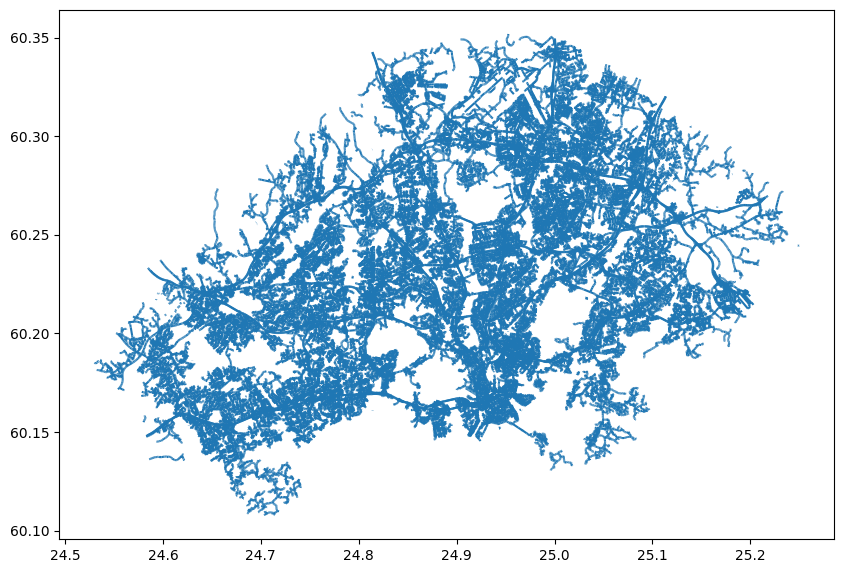

In [147]:
from pyrosm import OSM, get_data
import geopandas as gpd
import pandas as pd
import networkx as nx

# We will use test data for Helsinki that comes with pyrosm
##osm = OSM(get_data("helsinki_pbf"))
osm = OSM("data/Helsinki_larger_region.osm.pbf")

# Parse roads that can be driven by car
roads = osm.get_network(network_type="driving")
roads.plot(figsize=(10,10))

(60.12, 60.35)

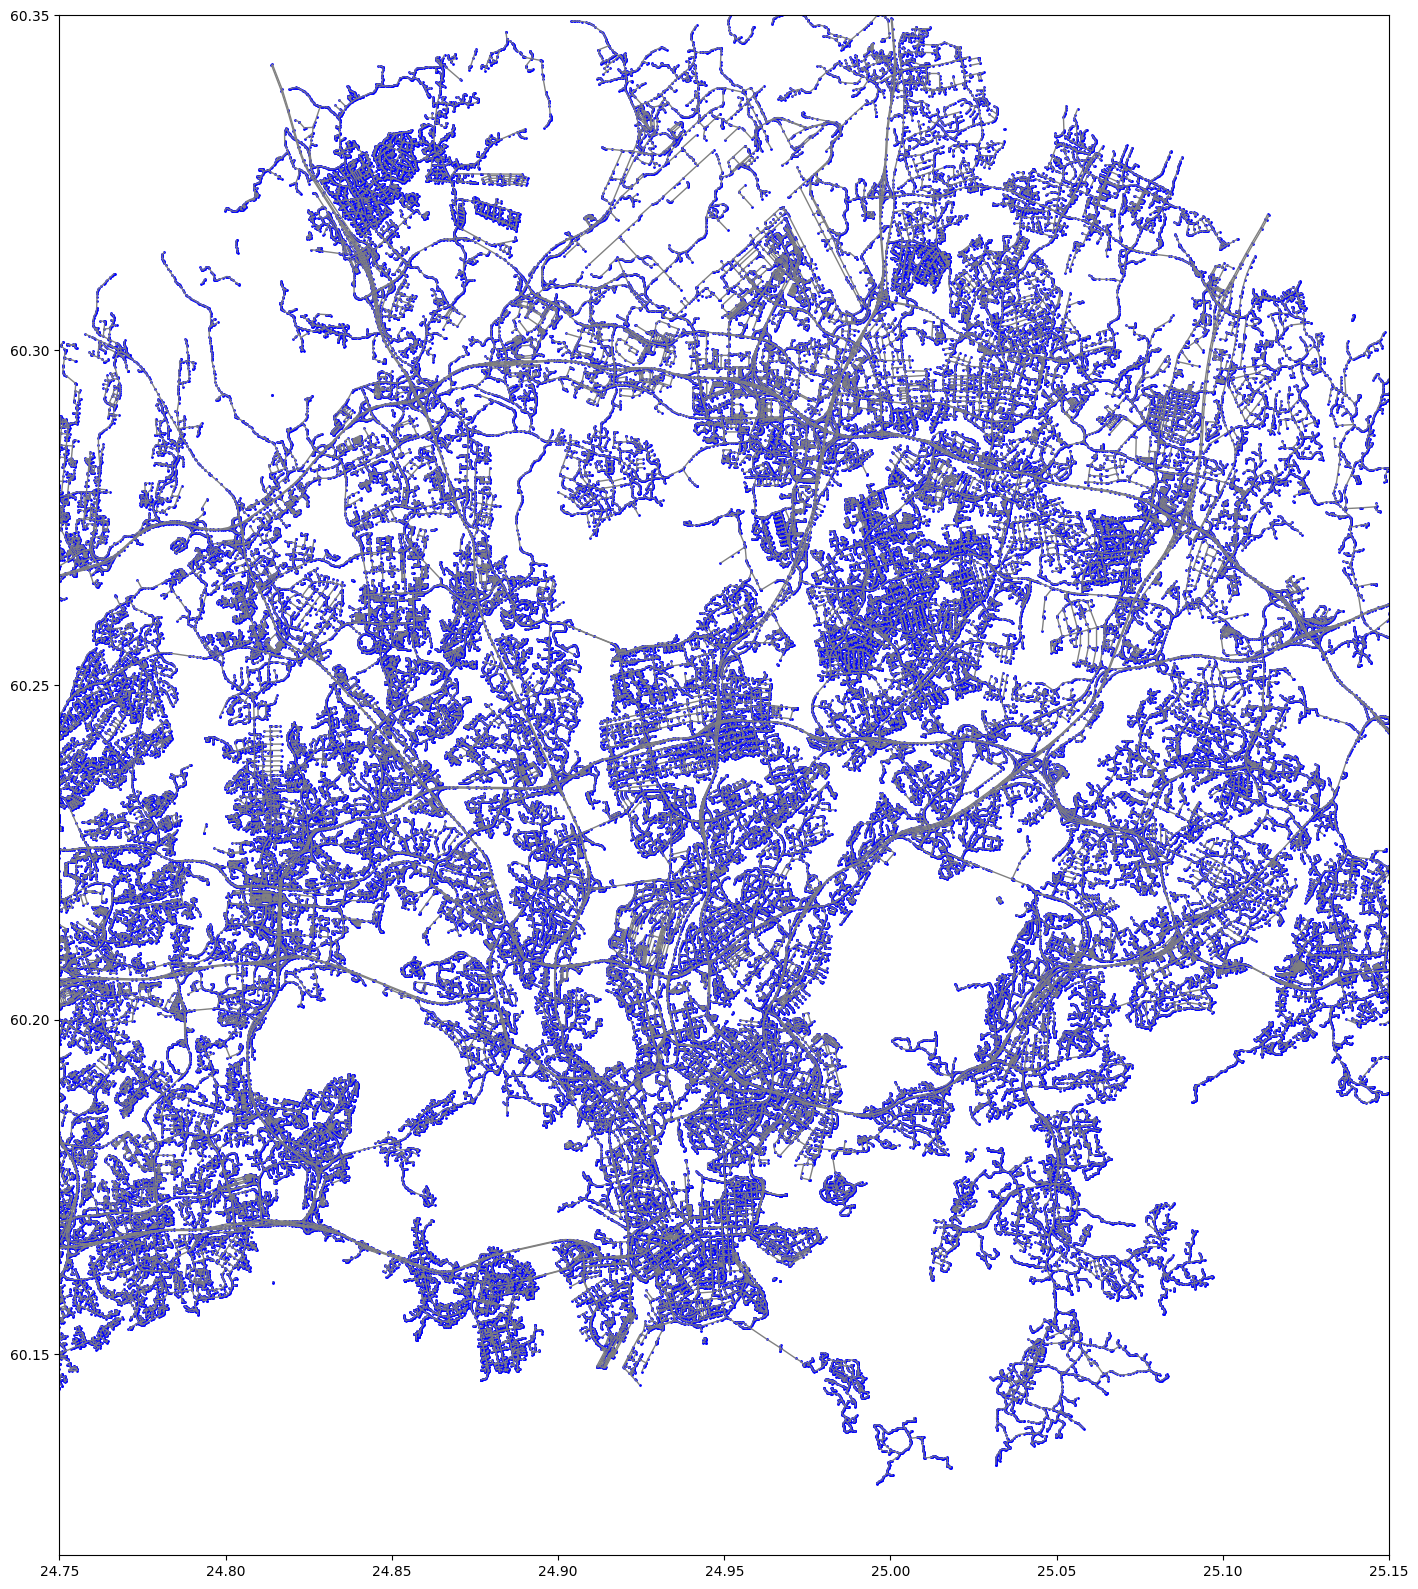

In [148]:
# Parse nodes and edges
nodes, edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = edges.plot(figsize=(20,20), color="grey", lw=1.0)
ax = nodes.plot(ax=ax, color="blue", markersize=1)

# Zoom in to take a closer look
ax.set_xlim([24.75, 25.15])
ax.set_ylim([60.12, 60.35])

In [149]:
boundaries = osm.get_boundaries()
boundaries.head(10)

visible admin_level        boundary        id   timestamp  version  \
0   False          11  administrative  39207517  1481962794        3   
1     NaN           8  administrative   2297753  1711216403       90   
2     NaN           8  administrative   2332673  1664824397       85   
3     NaN           8  administrative   2367831  1660067508       33   
4     NaN           8  administrative   2402990  1715340221       38   
5     NaN           8  administrative   2510036  1716223296       81   
6     NaN           8  administrative   2546135  1684664671       38   
7     NaN           8  administrative   2730719  1605787932       21   
8     NaN          10  administrative  75501525  1711724805       25   
9     NaN          10  administrative  75686181  1662059814        6   

   osm_type                                           geometry         name  \
0       way  MULTILINESTRING ((25.15327 60.19659, 25.14662 ...          NaN   
1  relation  POLYGON ((24.78280 60.09996, 24.83567 60.13041...     Helsinki   
2  relation  POLYGON ((24.76093 60.32537, 24.94720 60.33626...       Vantaa   
3  relation  POLYGON ((24.87728 60.38229, 25.03366 60.34131...      Tuusula   
4  relation  MULTIPOLYGON (((25.22032 60.19982, 25.20141 60...        Sipoo   
5  relation  MULTIPOLYGON (((24.66420 60.14250, 24.69858 60...        Espoo   
6  relation  POLYGON ((24.64954 60.11478, 24.64785 60.11760...  Kirkkonummi   
7  relation  POLYGON ((24.67575 60.21186, 24.67528 60.21103...   Kauniainen   
8  relation  POLYGON ((24.83802 60.14284, 24.83943 60.15026...  Lauttasaari   
9  relation  POLYGON ((24.89517 60.16674, 24.90064 60.16993...  Länsisatama   

   ref   url                  website postal_code border_type start_date  \
0  NaN   NaN                      NaN         NaN         NaN        NaN   
1  091  None                     None        None        None       None   
2  092  None                     None        None        None       None   
3  858  None                     None        None        None       None   
4  753  None    https://www.sipoo.fi/        None        None       None   
5  049  None                     None        None        None       None   
6  257  None                     None        None        None       None   
7  235  None                     None        None        None       None   
8   31  None  https://lauttasaari.fi/        None        None       None   
9   20  None                     None        None        None       None   

   changeset                                               tags  
0        NaN                                                NaN  
1        0.0  {"alt_name":"Hesa;Stadi","alt_name:grc":"\u1F1...  
2        0.0  {"name:da":"Vanda","name:fi":"Vantaa","name:is...  
3        0.0  {"name:fi":"Tuusula","name:ru":"\u0422\u0443\u...  
4        0.0  {"name:fi":"Sipoo","name:ru":"\u0421\u0438\u04...  
5        0.0  {"alt_name":"Epsoo;Spoo;Esbobo;Esboo;Esbou;Esb...  
6        0.0  {"name:fi":"Kirkkonummi","name:ru":"\u041A\u04...  
7        0.0  {"loc_name":"Grani","name:fi":"Kauniainen","na...  
8        0.0  {"loc_name":"Laru","name:fi":"Lauttasaari","na...  
9        0.0  {"name:fi":"L\u00E4nsisatama","name:sv":"V\u00...

{'type': 'Polygon',
 'coordinates': [[[24.5621395111084, 60.165916442871094],
   [24.516387939453125, 60.195518493652344],
   [24.55392837524414, 60.222660064697266],
   [24.62380027770996, 60.245906829833984],
   [24.662078857421875, 60.25482940673828],
   [24.70703247011368, 60.28691211588885],
   [24.718355178833008, 60.29851150512695],
   [24.76092529296875, 60.325374603271484],
   [24.77657683098504, 60.32628922962586],
   [24.876628875732422, 60.38246154785156],
   [24.87672233581543, 60.3824577331543],
   [24.877023696899414, 60.38247299194336],
   [24.877561569213867, 60.38208770751953],
   [24.877350623510978, 60.38223881046983],
   [24.87735062351098, 60.38223881046983],
   [24.87727663997722, 60.38229180576706],
   [25.033660888671875, 60.341312408447266],
   [25.03767967224121, 60.342342376708984],
   [25.070791244506836, 60.335906982421875],
   [25.0711925943563, 60.335530499353666],
   [25.116960525512695, 60.3284797668457],
   [25.139869689941406, 60.319366455078125],
  

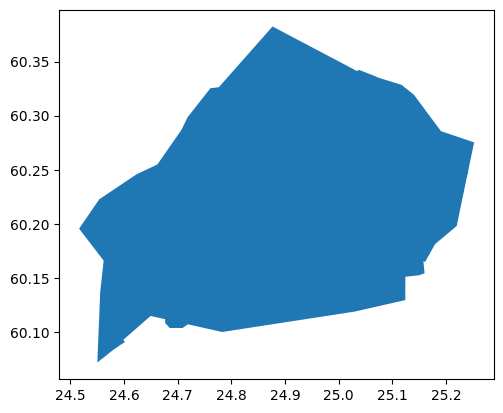

In [150]:
#boundaries.plot(facecolor="lightblue", edgecolor="blue")
zones = boundaries.dissolve(by='boundary')
zones.plot()
import json
geojson_dict_data = json.loads(zones.geometry.to_json())['features'][0]['geometry']
geojson_dict_data

In [151]:
import h3
h3.versions()
#h3.polygon_to_cells
#Hexes = h3.polygon_to_cells(zones.geometry.values[0], res=9, geo_json_conformant=False)
Hexes = h3.polyfill(geojson_dict_data, res=9, geo_json_conformant=False)
len(Hexes)

15265

In [156]:
len(u_OD)
u_OD[u_OD.id.isin(list(Hexes))]

Empty DataFrame
Columns: [id, lat, lon, geometry]
Index: []

In [152]:
import sys
sys.argv.append([
    "--r5-classpath", 
    "https://github.com/DigitalGeographyLab/r5/releases/download/v6.9-post16-g1054c1e-20230619/r5-v6.9-post16-g1054c1e-20230619-all.jar"
])

import pandas as pd
import geopandas as gpd
import osmnx as ox
import r5py
import r5py.sampledata.helsinki

from r5py import TransportNetwork

# Get the filepaths to sample data (OSM and GTFS)
helsinki_osm = "data/Helsinki_larger_region.osm.pbf" #r5py.sampledata.helsinki.osm_pbf
helsinki_gtfs = r5py.sampledata.helsinki.gtfs

transport_network = TransportNetwork(
    # OSM data
    helsinki_osm,
    # A list of GTFS file(s)
    [
        helsinki_gtfs
    ]
)

### Calculating GHG emission for locomizer data
We aim to create a square matrix where rows and columns are the hexagon IDs of the h3 OD hexagons. The matrix entities are the total GHG emissions due to PT trips according to the locomizer data.  

In [138]:
loco_df_ = loco_df_all[loco_df_all.DAY == "2023-05-28"].copy()
loco_df_May = loco_df_[loco_df_['ORIGIN_CODE_R9'] != loco_df_['DESTINATION_CODE_R9']].copy()#drop_duplicates(subset=['ORIGIN_CODE_R9','DESTINATION_CODE_R9'],keep=False)#.set_index(["ORIGIN_CODE_R9","DESTINATION_CODE_R9"])
loco_df_May.head()
#loco_df_May.apply(lambda x: print(x.ORIGIN_CODE_R9,x.DESTINATION_CODE_R9),axis=1)
##x = loco_df_May.iloc[1]#["ORIGIN_CODE_R9","DESTINATION_CODE_R9"]
##x.ORIGIN_CODE_R9,x.DESTINATION_CODE_R9
##car_OD_co2_dict['ghg_co2_emission_Car'][(x.ORIGIN_CODE_R9,x.DESTINATION_CODE_R9)]
##loco_df_May["Single_CarTrip_Co2"] = loco_df_May.apply(lambda x: car_OD_co2_dict['ghg_co2_emission_Car'][(x.ORIGIN_CODE_R9, x.DESTINATION_CODE_R9)],axis=1)
## dict[column][key] = value

AttributeError: 'DataFrame' object has no attribute 'DAY'

In [ ]:
##from r5py import DetailedItinerariesComputer

##detailed_itineraries_computer = DetailedItinerariesComputer(
##    transport_network,
##    origins= hexagon_Centroid_gdf,
##    destinations= hexagon_Centroid_gdf,
##    departure=datetime.datetime(2022,2,22,8,30),
##    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK], 
    # With following attempts to snap all origin and destination points to the transport network before routing
##    snap_to_network=True,)
##All_Hex_travel_details = detailed_itineraries_computer.compute_travel_details()
##travel_details_gpd = gpd.GeoDataFrame(travel_details).to_crs(3387) ## Helsinki Projected coordinate system - EPSG:3387 KKJ / Finland (zone 5)  
##All_Hex_travel_details_gpd = gpd.GeoDataFrame(All_Hex_travel_details).to_crs(3067) ## Helsinki Projected coordinate system - EPSG:3387 KKJ / Finland (zone 5)  
All_Hex_travel_details_gpd = pd.read_csv("data/Helsinki_Hex_Det_Ite_r5r.csv", sep=",")
All_Hex_travel_details_gpd.head(20)

### Recalling Helsinki Regional Transport Authority (HSL) survey data
Here, we recall the HSL survey on the number of trips within the residents of the Helsinki region and the survey report contains the following ratio of travel mode share in the total HSL area:

In [ ]:
Car_share_Hsl = 0.35 ## Henkilöauto
PT_share_Hsl = 0.23 ## Joukkoliikenne
Bike_share_Hsl = 0.08  ## Polkupyörä
Walk_share_Hsl = 0.33  ## Kävely
Other_share_Hsl = 0.01 ## Muu

## Where to go next?

In case you want to learn more, we recommend reading:
- [r5py documentation](https://r5py.readthedocs.io/) that provides much more details on how to use `r5py`.